# constants

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.linalg import solve
import pandas as pd
from scipy.interpolate import interp1d


# --- Physical and Wave Parameters ---

rho_w = 1025.0       # [kg/m^3] Density of seawater
g = 9.81             # [m/s^2] Gravitational acceleration
Hs = 1.95            # [m] Significant wave height (Hm0)
Tp = 5.59            # [s] Peak wave period
tan_beta = 1.0 / 3.0 # [-] Slope of the revetment (tan(beta) = 1/3 for 1:3 slope)

# --- Filter and Soil Properties ---

D = 0.30             # [m] Thickness of the top (impervious) layer
b = 0.30             # [m] Thickness of the filter layer beneath --reset=0.13
k = 0.19             # [m/s] Permeability of the filter layer
k_prime = 0.05       # [m/s] Permeability of the base layer below the filter

# --- Derived Parameter ---

Lambda = np.sqrt(D * b * k / k_prime)  # [m] Leakage length (controls pressure dissipation)



# P max

In [8]:
# Step 1: Estimate mean period
Tm_1_0 = Tp / 1.1

# Step 2: Calculate wavelength
L_m_1_0 = (g * Tm_1_0**2) / (2.0 * np.pi)

# Step 3: Calculate Iribarren number
xi_m_1_0 = tan_beta / np.sqrt(Hs / L_m_1_0)

# Step 4: Evaluate the dimensionless pressure formula
denominator = (xi_m_1_0 - 0.2)**2
if denominator == 0:
    raise ValueError("Denominator in pressure equation is zero.")

P_dimless = 8.0 - 1.6 * xi_m_1_0 - 2.0 / denominator

# Step 5: Convert to dimensional pressure
P_max = P_dimless * rho_w * g * Hs  # in Pascals

# Convert to kPa
H_max = P_max / (9.81 * 1025.0)

# Print results
print("Tm-1,0:       %.3f s" % Tm_1_0)
print("L_m-1,0:      %.3f m" % L_m_1_0)
print("xi_m-1,0:     %.3f"   % xi_m_1_0)
print("P* (dimless): %.3f"   % P_dimless)
print("P_max:        %.2f Pa" % P_max)
print("H_max:        %.2f m" % H_max)


Tm-1,0:       5.082 s
L_m-1,0:      40.321 m
xi_m-1,0:     1.516
P* (dimless): 4.420
P_max:        86656.97 Pa
H_max:        8.62 m


# plot pressure plus response

Max value of the residual force: 26883.24 Pa
Min value of the residual force: -34391.41 Pa


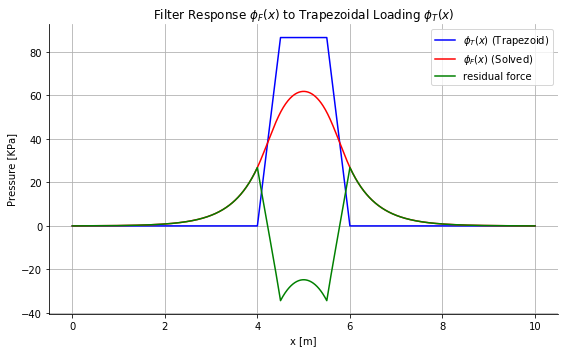

In [18]:

%matplotlib inline

# Force white background
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Discretization
dx = 0.01
L = 10.0
x = np.arange(0, L + dx, dx)
N = len(x)

# Build phi_T (trapezoidal loading)
wave_impact = np.piecewise(
    x,
    [x < 4, (x >= 4) & (x < 4.5), (x >= 4.5) & (x < 5.5), (x >= 5.5) & (x < 6), x >= 6],
    [
        0,
        lambda x: (x - 4) * (P_max / 0.5),
        P_max,
        lambda x: P_max - (x - 5.5) * (P_max / 0.5),
        0
    ]
)

# Source term vector: b = -phi_T
b_vec = -wave_impact.copy()
b_vec[0] = 0
b_vec[-1] = 0

# Construct coefficient matrix A
A = np.zeros((N, N))
coeff = Lambda**2 / dx**2

for i in range(1, N - 1):
    A[i, i - 1] = coeff
    A[i, i]     = -2 * coeff - 1
    A[i, i + 1] = coeff

# Apply boundary conditions
A[0, 0] = 1.0
A[-1, -1] = 1.0

# Solve
phi_F = solve(A, b_vec)

# residual force
residual_force = phi_F - wave_impact

#print max and min values
print("Max value of the residual force: %.2f Pa" % np.max(residual_force))
print("Min value of the residual force: %.2f Pa" % np.min(residual_force))

# Plot using ax
fig, ax = plt.subplots(figsize=(8, 5)) # Create a figure and an axes object

ax.plot(x, wave_impact/1000, label=r'$\phi_T(x)$ (Trapezoid)', color='blue')
ax.plot(x, phi_F/1000, label=r'$\phi_F(x)$ (Solved)', color='red')
ax.plot(x, residual_force/1000, label=r'residual force', color='green')

ax.set_xlabel('x [m]')
ax.set_ylabel('Pressure [KPa]')
ax.legend()
ax.grid(True)
ax.set_title('Filter Response $\phi_F(x)$ to Trapezoidal Loading $\phi_T(x)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [10]:


# --- 1. Define block geometry ---
x_start, y_start = 1.86, 6.05          # Starting position of first block
block_width = 0.5                      # Block width [m]
block_height = 0.15                    # Block height [m]
n_blocks = 22                          # Number of blocks
slope = 1 / 3                          # Revetment slope (1:3)

angle_rad = np.arctan(slope)          # Slope angle in radians
block_x = [x_start + i * block_width * np.cos(angle_rad) for i in range(n_blocks)]
block_y = [y_start + i * block_width * np.sin(angle_rad) for i in range(n_blocks)]
block_x_centers = [
    block_x[j] + np.cos(angle_rad) * (block_width / 2)
    for j in range(n_blocks)
]
#temporary attempt
block_x_centers = np.linspace(2.0, 12.5, 22)

# --- 2. Compute normalized residual profile from steady-state solution ---
residual_profile = phi_F - wave_impact

# Interpolate residual profile along x
residual_head_from_x = interp1d(x, residual_profile, bounds_error=False, fill_value=0)
block_heads_residual = residual_head_from_x(block_x_centers)

# --- 3. Time pulse definition ---
tt = np.linspace(0, 4, 200)
pulse_shape = np.zeros_like(tt)
pulse_indices = (tt >= 2.0) & (tt <= 2.25)
pulse_t = tt[pulse_indices] - 2.0
pulse_shape[pulse_indices] = np.interp(pulse_t, [0, 0.05, 0.25], [0, 1, 0])  # Normalized triangle

# Time interpolation function
residual_func = interp1d(tt, pulse_shape, kind='linear', fill_value=0, bounds_error=False)


# --- 4. Construct time-resolved force table ---
time_high_res = np.arange(0, 11.991, 0.01)
data = []
for t in time_high_res:
    t_mod = t % 4  # Pulse repeats every 4 seconds
    res_val = residual_func(t_mod)
    forces = np.round(block_heads_residual * res_val, 5)  # Convert to N, round to 5 decimals
    data.append([round(t, 3)] + list(forces))

# --- 5. Build DataFrame and export ---
columns = ["TIME"] + [f"ROW{i+1}" for i in range(n_blocks)]
df = pd.DataFrame(data, columns=columns)

# Export to CSV
df.to_csv("residual_forces_table.csv", index=False)

# Optional preview
df.head()

# --- 6. Print max and min of each column ---
print("MAXIMUM VALUES PER COLUMN:")
print(df.max(numeric_only=True))

print("\nMINIMUM VALUES PER COLUMN:")
print(df.min(numeric_only=True))


MAXIMUM VALUES PER COLUMN:
TIME        11.99000
ROW1       873.12616
ROW2      2054.78995
ROW3      4832.20929
ROW4     11362.33572
ROW5     26716.48347
ROW6        -0.00000
ROW7        -0.00000
ROW8        -0.00000
ROW9     26716.48347
ROW10    11362.33572
ROW11     4832.20929
ROW12     2054.78995
ROW13      873.12616
ROW14      369.53457
ROW15      152.92454
ROW16       55.07613
ROW17        0.00000
ROW18        0.00000
ROW19        0.00000
ROW20        0.00000
ROW21        0.00000
ROW22        0.00000
dtype: float64

MINIMUM VALUES PER COLUMN:
TIME         0.00000
ROW1         0.00000
ROW2         0.00000
ROW3         0.00000
ROW4         0.00000
ROW5         0.00000
ROW6    -34178.08252
ROW7    -24618.63322
ROW8    -34178.08252
ROW9         0.00000
ROW10        0.00000
ROW11        0.00000
ROW12        0.00000
ROW13        0.00000
ROW14        0.00000
ROW15        0.00000
ROW16        0.00000
ROW17        0.00000
ROW18        0.00000
ROW19        0.00000
ROW20        0.00000
ROW21 

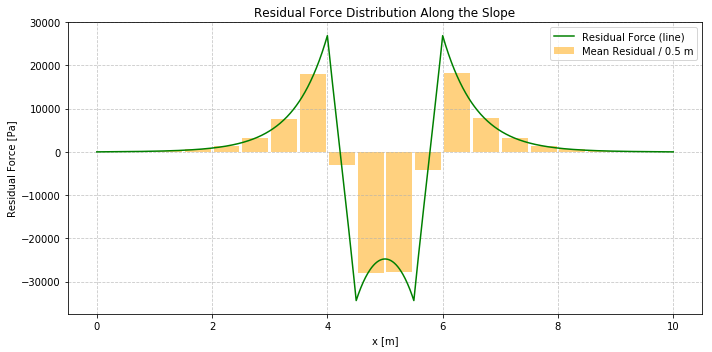

In [11]:

# Step 1: Bin edges every 0.5 m along the slope
bin_width = 0.5
x_bins = np.arange(x[0], x[-1] + bin_width, bin_width)

# Step 2: Digitize x to assign each residual point to a bin
bin_indices = np.digitize(x, x_bins)

# Step 3: Compute average residual force per bin
bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
residual_means = []
for i in range(1, len(x_bins)):
    bin_mask = bin_indices == i
    bin_values = (phi_F - wave_impact)[bin_mask]
    if len(bin_values) > 0:
        residual_means.append(np.mean(bin_values))
    else:
        residual_means.append(0.0)

# Step 4: Plot both line and histogram
plt.figure(figsize=(10, 5))

# Line plot of residual force
plt.plot(x, phi_F - wave_impact, label='Residual Force (line)', color='green')

# Histogram-style plot (bars)
plt.bar(bin_centers, residual_means, width=bin_width * 0.9,
        alpha=0.5, align='center', label='Mean Residual / 0.5 m', color='orange')

plt.xlabel('x [m]')
plt.ylabel('Residual Force [Pa]')
plt.title('Residual Force Distribution Along the Slope')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
inp_lines = []

for col in df.columns[1:]:  # Skip "TIME", use "ROW1" to "ROW22"
    inp_lines.append(f"*AMPLITUDE, NAME={col}\n")
    
    for t, val in zip(df["TIME"], df[col]):
        inp_lines.append(f"{t:.3f}, {val:.5f},\n")  # Format: time, force
    
    inp_lines.append("\n")  # Separate blocks

# Preview first few lines
print("".join(inp_lines[:30]))
with open("block_amplitudes.inp", "w") as f:
    f.writelines(inp_lines)

print("✅ File 'block_amplitudes.inp' created with amplitudes per block (ROW1 to ROW22)")

*AMPLITUDE, NAME=ROW1
0.000, 0.00000,
0.010, 0.00000,
0.020, 0.00000,
0.030, 0.00000,
0.040, 0.00000,
0.050, 0.00000,
0.060, 0.00000,
0.070, 0.00000,
0.080, 0.00000,
0.090, 0.00000,
0.100, 0.00000,
0.110, 0.00000,
0.120, 0.00000,
0.130, 0.00000,
0.140, 0.00000,
0.150, 0.00000,
0.160, 0.00000,
0.170, 0.00000,
0.180, 0.00000,
0.190, 0.00000,
0.200, 0.00000,
0.210, 0.00000,
0.220, 0.00000,
0.230, 0.00000,
0.240, 0.00000,
0.250, 0.00000,
0.260, 0.00000,
0.270, 0.00000,
0.280, 0.00000,

✅ File 'block_amplitudes.inp' created with amplitudes per block (ROW1 to ROW22)


In [13]:
# 1. Read the .inp file
with open("Job-2-no-amps.inp", "r") as f:
    lines = f.readlines()

# 2. Find line number containing '** End Assembly'
end_assembly_line = None
for i, line in enumerate(lines):
    if line.strip() == "*End Assembly":
        end_assembly_line = i
        break

# 3. Insert 'amplitudes' after '** End Assembly'
if end_assembly_line is not None:
    lines.insert(end_assembly_line + 1, 'amplitudes\n')
    print("✅ Inserted 'amplitudes' after line number:", end_assembly_line)
else:
    print("❌ '** End Assembly' not found in file.")

# 4. Export to new .inp file
with open("Job-test.inp", "w") as f:
    f.writelines(lines)


✅ Inserted 'amplitudes' after line number: 4510


In [20]:
# 1. Read the original .inp file
with open("Job-2-no-amps.inp", "r") as f:
    lines = f.readlines()

# 2. Find line number of '*End Assembly'
end_assembly_line = None
for i, line in enumerate(lines):
    if line.strip() == "*End Assembly":
        end_assembly_line = i
        break

# 3. Ensure TIME is strictly increasing and unique
if not (df["TIME"].is_monotonic_increasing and df["TIME"].is_unique):
    raise ValueError("❌ TIME column must be strictly increasing and contain no duplicates.")

# 4. Build amplitude lines with 4 pairs per line and no trailing commas or blank lines
amplitude_lines = []

for col in df.columns[1:]:  # Skip "TIME"
    amplitude_lines.append(f"*AMPLITUDE, NAME={col}\n")

    for i in range(0, len(df), 4):
        chunk = df.iloc[i:i+4]
        row_entries = []
        for t, val in zip(chunk["TIME"], chunk[col]):
            row_entries.append(f"{t:.3f}, {val:.5f}")
        line = ", ".join(row_entries)  # No trailing comma
        amplitude_lines.append(line + "\n")

# 5. Insert amplitude lines after '*End Assembly'
if end_assembly_line is not None:
    lines = lines[:end_assembly_line + 1] + amplitude_lines + lines[end_assembly_line + 1:]
    print("✅ Amplitudes inserted after '*End Assembly'")
else:
    raise RuntimeError("❌ '*End Assembly' not found in file.")

# 6. Write the new .inp file
with open("Job-test.inp", "w") as f:
    f.writelines(lines)

print("✅ Clean .inp file written to 'Job-test.inp'")


✅ Amplitudes inserted after '*End Assembly'
✅ Clean .inp file written to 'Job-test.inp'
